In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import numpy.linalg as npl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score
from pathlib import Path

In [2]:
plt.rcParams.update({'font.size': 22,
                     'xtick.labelsize': 15,
                     'ytick.labelsize': 15,
                     'legend.fontsize': 20,
                     'legend.fancybox': True})

def adapt_save_fig_top(fig, filename='test.svg'):
    for ax in fig.get_axes():
        ax.spines['top'].set_visible(False)
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    
# right spine not visible
def adapt_save_fig(fig, filename='test.svg'):
    for ax in fig.get_axes():
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight")

In [3]:
# Load the metamodel and the data used for training
from dfba_sampling.metamodel import Metamodel

mm_fprau = Metamodel(constraints="data/constraints_2100_train.tsv", fluxes="data/fluxes_fprau_2100_train.tsv")
mm_styphi = Metamodel(constraints="data/constraints_2100_train.tsv", fluxes="data/fluxes_styphi_2100_train.tsv")

mm = [mm_styphi, mm_fprau]
for m in mm:
    m.P_MaxOrder(3)
    m.gen_Wv()

/home/simon/Documents/SVN_GIT/SLIMMEST/python-dfba-sampling/.tox/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


# Loss function

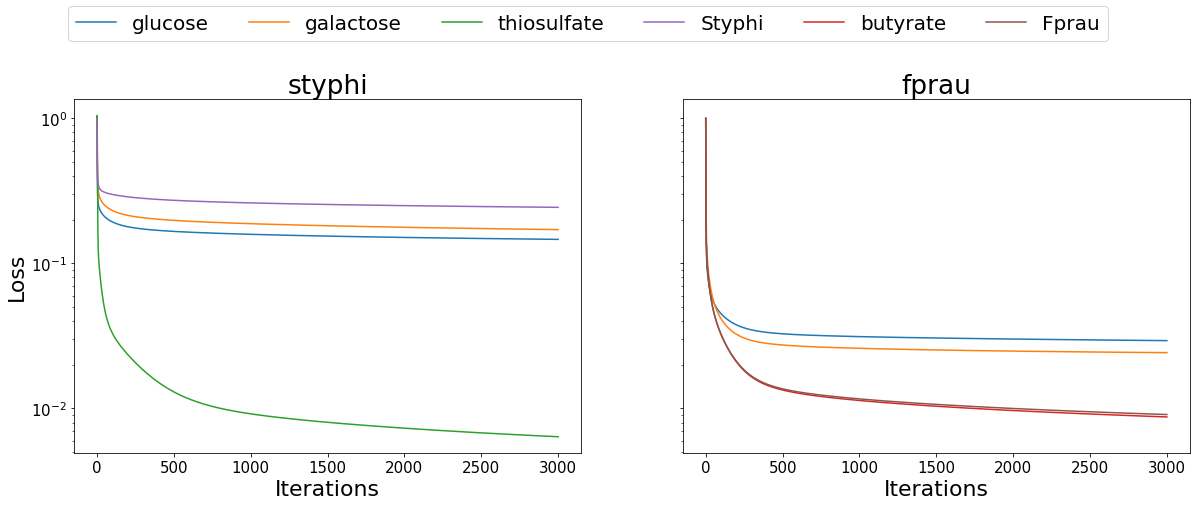

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6.5), sharey=True)
for k, s in enumerate(["styphi", "fprau"]):
    results = np.load(f"data/{s}/mu_0.0/metamodel_{s}_results.npz", allow_pickle=True)
    for j in range(6):
        if results["loss"][j][0]:
            axes[k].plot(results["loss"][j], color=f'C{j}', label=mm_fprau.compound_name[j])
        axes[k].set_yscale("log")
        axes[k].set_xlabel("Iterations")
        axes[k].set_title(s)
handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()
handles = handles1 + handles2[2:]
labels = labels1 + labels2[2:]
axes[0].set_ylabel("Loss")
fig.legend(handles, labels, ncol=6, bbox_to_anchor=(.85, 1.1))
#adapt_save_fig(fig, "loss.pdf")
plt.show()

# Lasso paths

In [5]:
regs = [0.0, .001, .01, .05, .1, .2, .3, .4, .5, .6, .75, 1.]
nregs = len(regs)
ncomp = 6
parts = ['glucose', 'galactose', 'thiosulfate', 'glucose & galactose', 'glucose & thiosulfate', 'galactose & thiosulfate', 'glucose & galactose & thiosulfate']
nparts = len(parts)
species = ["styphi", "fprau"]
nbacts = len(species)
lasso_path = np.zeros([nbacts, nregs, ncomp, nparts])
loss = np.zeros([nbacts, nregs, ncomp])

c_test = pd.read_csv("data/constraints_300_test.tsv", sep="\t").values
s_test = pd.read_csv("data/fluxes_styphi_300_test.tsv", sep="\t").values
p_test = pd.read_csv("data/fluxes_fprau_300_test.tsv", sep="\t").values

ypred = np.zeros([len(s_test), ncomp])
test = np.zeros([nbacts, s_test.shape[0], s_test.shape[1]])
test[0] = s_test
test[1] = p_test

for j, s in enumerate(species):
    mm[j].gen_Wv()
    for i,r in enumerate(regs):
        results = np.load(f"data/{s}/mu_{r}/metamodel_{s}_results.npz")
        mm[j].theta = results["theta"]
        mm[j].theta_0 = results["theta_0"]
        reg_v = [
        [npl.norm(mm[j].W[v,:,:].dot(mm[j].theta[: ,v,i_compound])) for v in range(mm[j].Nv)]
        for i_compound in range(mm[j].Ncompound)
        ]
        lasso_path[j, i] = np.array(reg_v)
        for k, c, in enumerate(c_test):
            ypred[k, :] = mm[j].flux_estimate(c[None, :])
        for l in range(ncomp):
            if test[j][:, l].any():
                loss[j, i, l] = np.linalg.norm(ypred[:, l]-test[j, :, l],2) / np.linalg.norm(test[j, :, l])

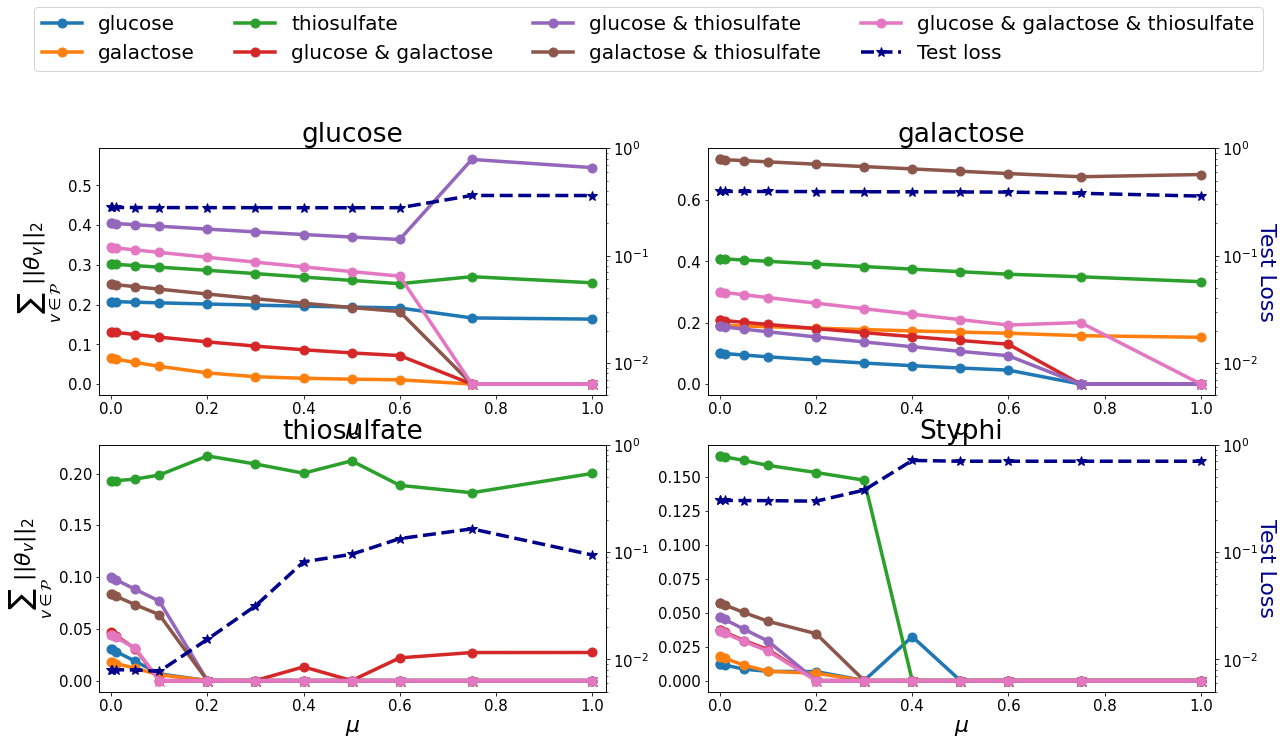

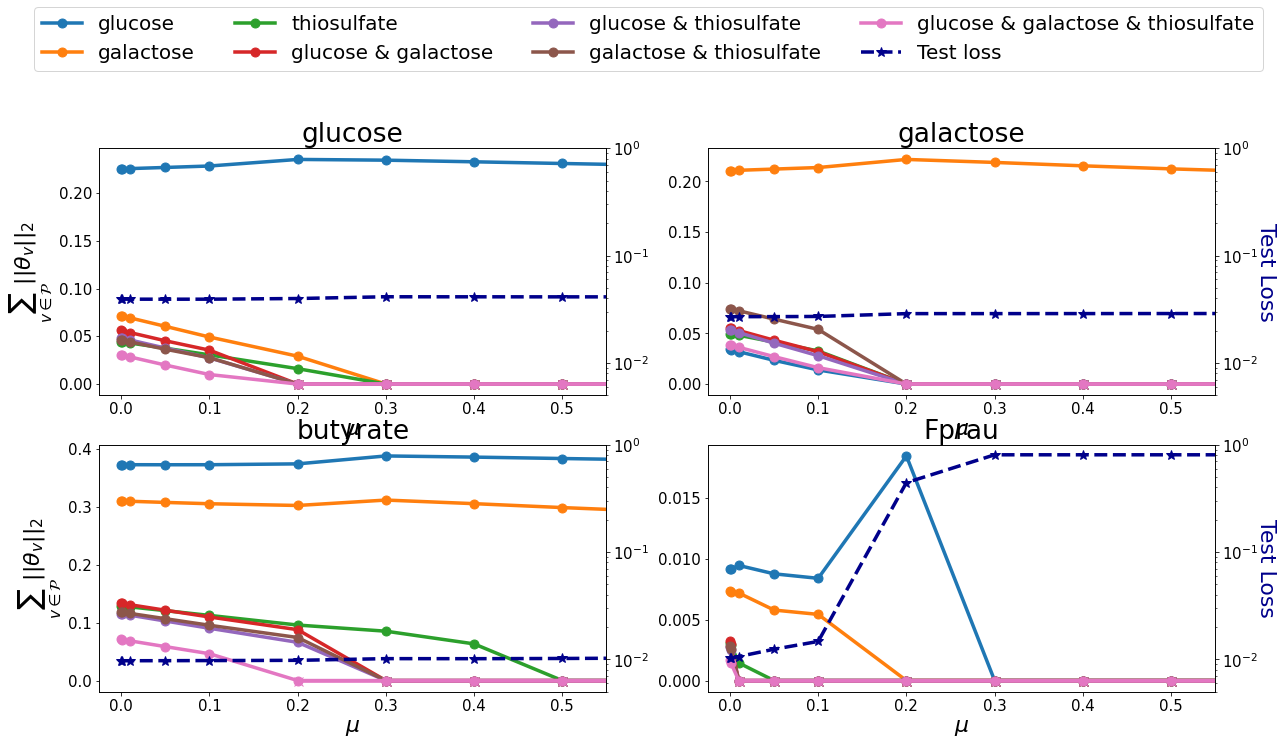

In [6]:
idx = [[0, 1, 2, 4], [0, 1, 3, 5]]
ylims = [[1.03, 1.03, 1.03, 1.03], [.55, .55, .55, .55]]
for k, s in enumerate(species):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        for j in range(nparts):
            lp = lasso_path[k, :, idx[k][i], j].T
            ax.plot(regs, lp, marker='o', color=f'C{j}', label=parts[j] if not i else None,
                    linewidth=3.5, markersize=9)
            ax.plot(regs, np.where(lp==0, lp, None), marker='x', markersize=9, color=f'C{j}',
                    linewidth=3.5)
        ax.set_xlabel("$\mu$")
        ax.set_ylabel(r"$\sum_{v \in \mathcal{P}} ||\theta_v||_2$" if i in [0, 2] else "")
        ax.set_xlim(-0.025, ylims[k][i])
        ax2 = ax.twinx()
        ax2.set_ylabel("Test Loss" if i in [1, 3] else "", rotation=-90, color="darkblue")
        ax2.yaxis.set_label_coords(1.12,.5)
        ax2.set_yscale("log")
        ax2.set_ylim(5e-3, 1)
        ax2.plot(regs, loss[k, :, idx[k][i]], 'darkblue', marker='*', linestyle='--',
                 label="Test loss" if not i else "", linewidth=3.5, markersize=11)
        ax.set_title(mm[k].compound_name[idx[k][i]])
    fig.legend(bbox_to_anchor=(.94, 1.09), ncol=4)
    #adapt_save_fig_top(fig, f"lasso_path_{s}.pdf")
    plt.show()

# QQ plot for test set

In [7]:
regparam = 0.0
ypred = np.zeros([nbacts, len(s_test), ncomp])
for k, s in enumerate(species):
    results = np.load(f"data/{s}/mu_{regparam}/metamodel_{s}_results.npz")
    mm[k].theta = results["theta"]
    mm[k].theta_0 = results["theta_0"]
    for i, c, in enumerate(c_test):
        ypred[k, i, :] = mm[k].flux_estimate(c[None, :])

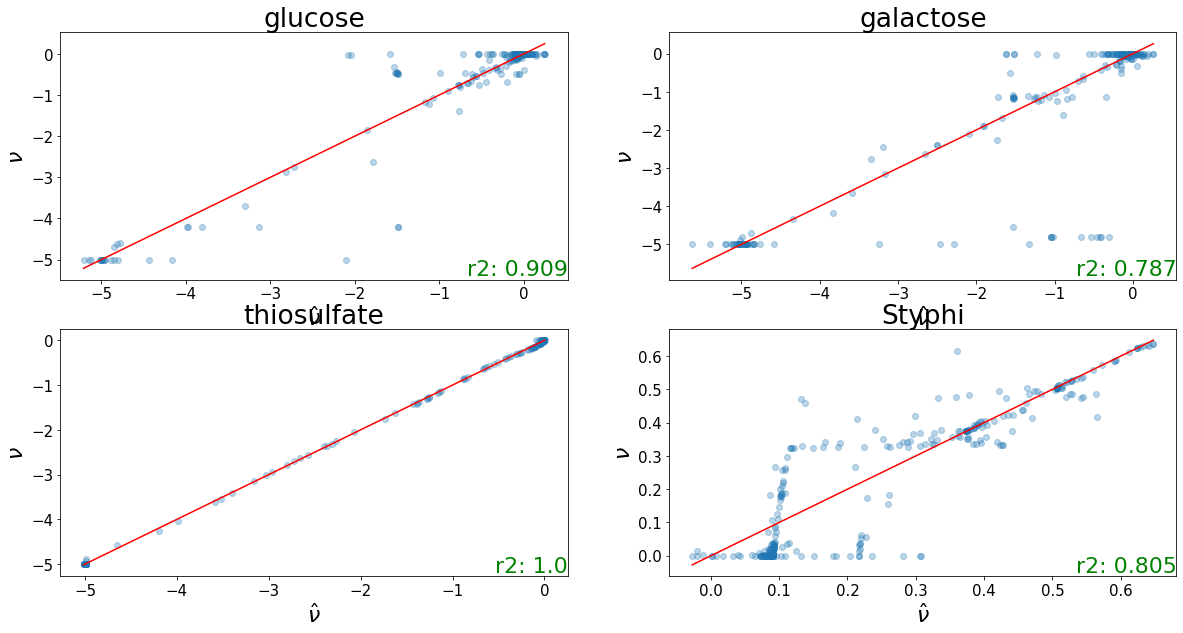

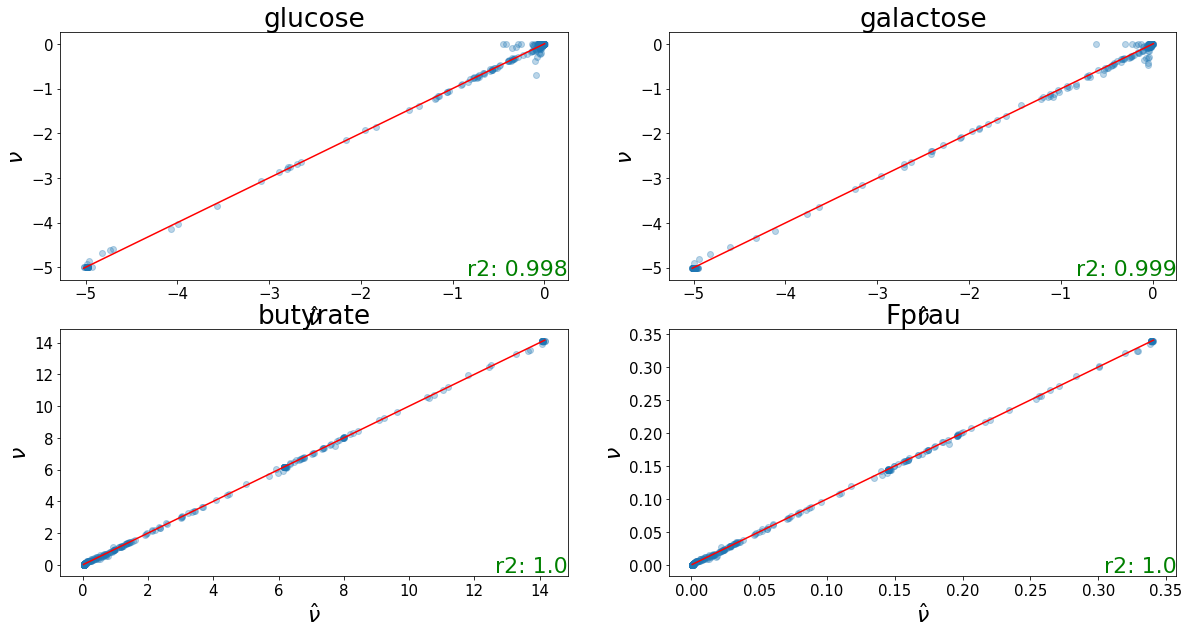

In [8]:
for k, s in enumerate(species):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        a = idx[k][i]
        ax.annotate(f"r2: {np.round(r2_score(test[k, :, a], ypred[k, :, a]),3)}",
                    xy=(1, 0),
                    color="green",
                    xycoords='axes fraction',
                    horizontalalignment='right', verticalalignment='bottom')
        ax.scatter(ypred[k, :, a], test[k, :, a], alpha=.3)
        ax.plot([ypred[k, :, a].min(), ypred[k, :, a].max()],
                [ypred[k,:, a].min(), ypred[k, :, a].max()],
                color='red')
        ax.set_title(mm[0].compound_name[a])
        ax.set_xlabel(r"$\hat{\nu}$")
        ax.set_ylabel(r"$\nu$")
    #adapt_save_fig(fig, f"qqplot_{s}.pdf")

# dFBA with mm / FBA

In [9]:
from dfba_sampling.dFBA import TimeIntegration
from dfba_sampling.vizu import PlotFBA, Plot
from dfba_sampling.metamodel import flux_metamodel_Wrapper
from dfba_sampling.FBA import FBA_model_Wrapper
from dfba_sampling.experiment import ExperimentSpec
from dfba_sampling.utils import gen_dict_metamodel

In [10]:
exp = ExperimentSpec(config="data/styphi_fprau_initial_conditions.yml",
                     networks=["data/Salmonella_FBA.xml", "data/Fprau_FBA.xml"])

dict_mm = gen_dict_metamodel(["Styphi", "Fprau"], mm,
                             ["data/styphi/mu_0.0/metamodel_styphi_results.npz", "data/fprau/mu_0.0/metamodel_fprau_results.npz"])

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [11]:
rng = np.random.default_rng(203)
exp.y0 = np.append(rng.uniform(0, 100, 4) * rng.choice(range(2), size=4, p=[.15, .85]),
                   rng.uniform(0, 1, 2))
exp.time = 15
exp.nb_timestep = 1501
#exp.y0[0] = 0 # simulating lack of glucose
y_fba,flux_fba,constraint_fba=TimeIntegration(exp)
y_mm,flux_mm,constraint_mm=TimeIntegration(exp, RHS=flux_metamodel_Wrapper, dict_mm=dict_mm)

t= 0.0 / 15 hours
t= 1.0 / 15 hours
t= 2.0 / 15 hours
t= 3.0 / 15 hours
t= 4.0 / 15 hours
t= 5.0 / 15 hours
t= 6.0 / 15 hours
t= 7.0 / 15 hours
t= 8.0 / 15 hours
t= 9.0 / 15 hours
t= 10.0 / 15 hours
t= 11.0 / 15 hours
t= 12.0 / 15 hours
t= 13.0 / 15 hours
t= 14.0 / 15 hours
t= 15.0 / 15 hours
t= 0.0 / 15 hours
t= 1.0 / 15 hours
t= 2.0 / 15 hours
t= 3.0 / 15 hours


/home/simon/Documents/SVN_GIT/SLIMMEST/python-dfba-sampling/.tox/py39/lib/python3.9/site-packages/dfba_sampling/dFBA.py:117: RuntimeWarning: divide by zero encountered in true_divide
  1 - experiment.time_step * flux_fba[id_neg] / y[id_neg]


t= 4.0 / 15 hours
t= 5.0 / 15 hours
t= 6.0 / 15 hours
t= 7.0 / 15 hours
t= 8.0 / 15 hours
t= 9.0 / 15 hours
t= 10.0 / 15 hours
t= 11.0 / 15 hours
t= 12.0 / 15 hours
t= 13.0 / 15 hours
t= 14.0 / 15 hours
t= 15.0 / 15 hours


In [12]:
norm = np.round(np.linalg.norm(y_mm[:, 1:] - y_fba[:, 1:], 2) / np.linalg.norm(y_fba[:, 1:], 2), 5)

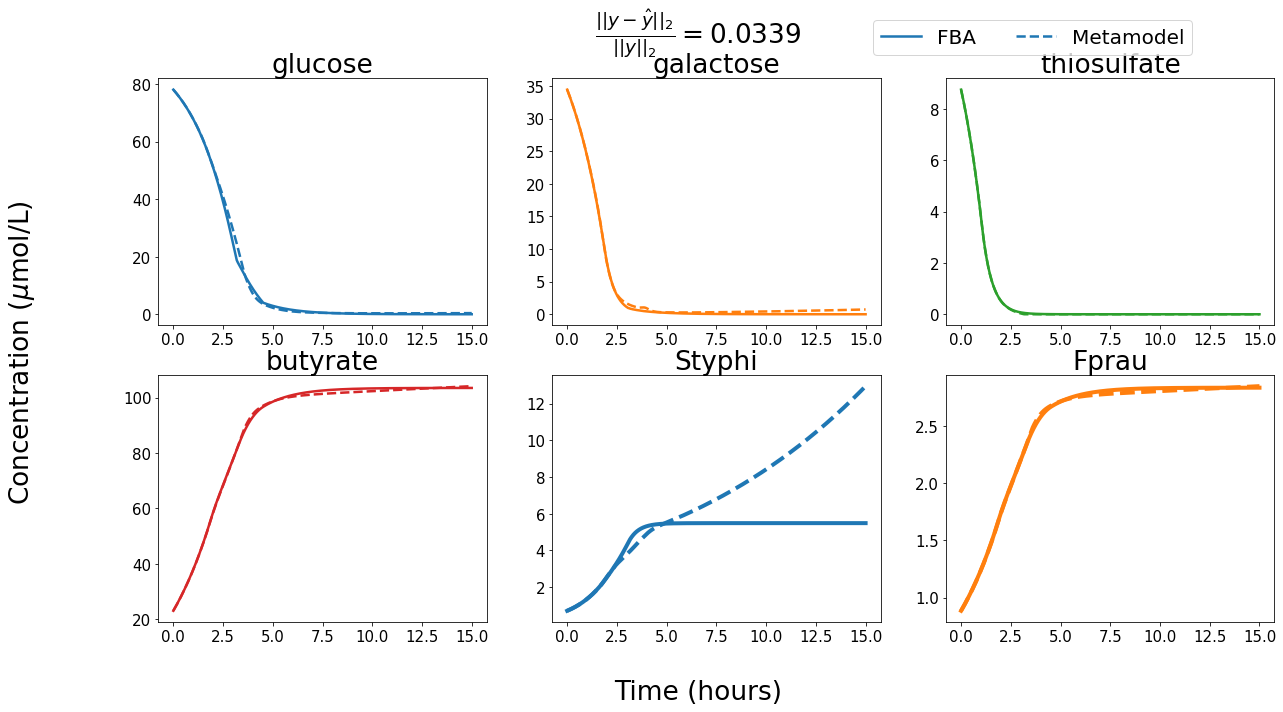

In [13]:
, exist_ok=Falsefig, axes = plt.subplots(2, 3, figsize=(20, 10))
colors = ["C0", "C1", "C2", "C3", "C0", "C1"]
for i, ax in enumerate(axes.flat):
    ax.plot(y_fba[:, 0], y_fba[:, i+1], linewidth=2.5 if i <4 else 4,
            color=colors[i], label="FBA" if not i else "")
    ax.plot(y_mm[:, 0], y_mm[:, i+1], linewidth=2.5 if i<4 else 4,
            color=colors[i], linestyle='--', label="Metamodel" if not i else "")
    ax.set_title(exp.compound_name[i])
fig.suptitle(r'$\frac{||y - \hat{y}||_2}{||y||_2} =0.0339$')
fig.supylabel(r"Concentration ($\mu$mol/L)")
fig.supxlabel("Time (hours)")
fig.legend(ncol=2, bbox_to_anchor=(.85, .975))
# adapt_save_fig(fig, "dFBA_long.pdf")
plt.show()

## Speedup dFBA w/ MM vs dFBA w/ FBA

In [14]:
nmodels = [50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2100]
rng = np.random.default_rng(1309)

n_it = 5
exp.nb_timestep = 1001
exp.time = 10
tps_dFBA = np.zeros(n_it)
tps_mm = np.zeros([n_it, len(nmodels)])
norms = np.zeros([n_it, len(nmodels)])
y0 = np.zeros([n_it, ncomp])
Y = np.zeros([n_it, exp.nb_timestep, ncomp])
for i in range(n_it):
    y0[i] = np.append(rng.uniform(0, 100, 4) * rng.choice(range(2), size=4, p=[.15, .85]),
                   rng.uniform(0, 1, 2))
    exp.y0 = y0[i]
    debut = time.time()
    y_fba, flux_fba, constraint_fba = TimeIntegration(exp)
    Y[i, :, :] = y_fba[:, 1:]
    fin = time.time()
    tps_dFBA[i] = fin - debut

C_learn = mm[0].C_learn.copy()
for j, n in enumerate(nmodels):
    for k, s in enumerate(species):
        results = np.load(f"data/{s}/n_obs_{n}/metamodel_{s}_results.npz")
        mm[k].new_constraintlearningset("data/constraints_2100_train.tsv", n_obs=n)
        mm[k].theta = results["theta"]
        mm[k].theta_0 = results["theta_0"]
        dict_mm[s.capitalize()] = mm[k]
    for i in range(n_it):
        exp.y0 = y0[i]
        debut = time.time()
        y_mm, flux_mm, constraint_mm = TimeIntegration(exp, RHS=flux_metamodel_Wrapper, dict_mm=dict_mm)
        fin = time.time()
        tps_mm[i, j] = fin - debut
        norms[i, j] = np.linalg.norm(y_mm[:, 1:] -  Y[i], 2) / np.linalg.norm(Y[i], 2)

t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.

/home/simon/Documents/SVN_GIT/SLIMMEST/python-dfba-sampling/.tox/py39/lib/python3.9/site-packages/dfba_sampling/dFBA.py:117: RuntimeWarning: divide by zero encountered in true_divide
  1 - experiment.time_step * flux_fba[id_neg] / y[id_neg]


t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.

/home/simon/Documents/SVN_GIT/SLIMMEST/python-dfba-sampling/.tox/py39/lib/python3.9/site-packages/dfba_sampling/dFBA.py:117: RuntimeWarning: overflow encountered in true_divide
  1 - experiment.time_step * flux_fba[id_neg] / y[id_neg]


t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.

t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.

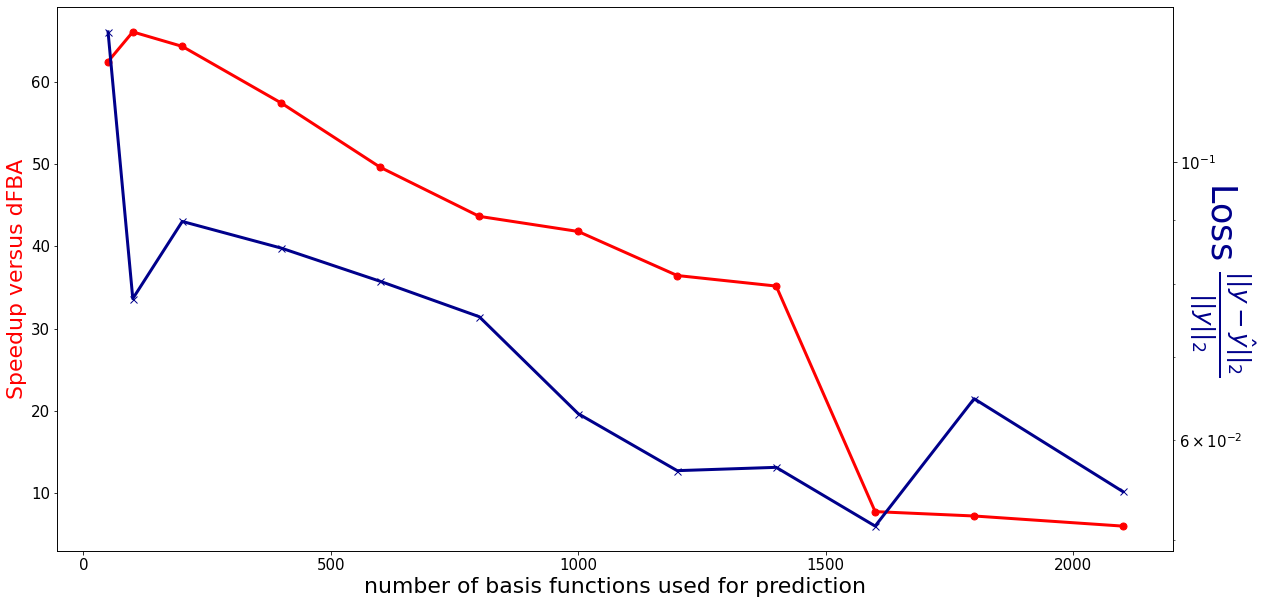

In [15]:
fig, axes = plt.subplots(1,  figsize=(20, 10))
axes.plot(nmodels, tps_dFBA.mean() / tps_mm.mean(axis=0), marker='o', color='red', linewidth=3, markersize=7)
axes.set_xlabel('number of basis functions used for prediction')
axes.set_ylabel("Speedup versus dFBA", color="red")
ax2 = axes.twinx()
ax2.plot(nmodels, norms.mean(axis=0), color='darkblue', linewidth=3, marker='x', markersize=7)
ax2.set_ylabel(r"Loss $\frac{||y - \hat{y}||_2}{||y||_2}$", rotation=-90, fontsize=35, color='darkblue')

ax2.yaxis.set_label_coords(1.075,.5)
ax2.set_yscale("log")
# adapt_save_fig_top(fig, "speedup_dFBA.pdf")
plt.show()

## Plot matern kernel

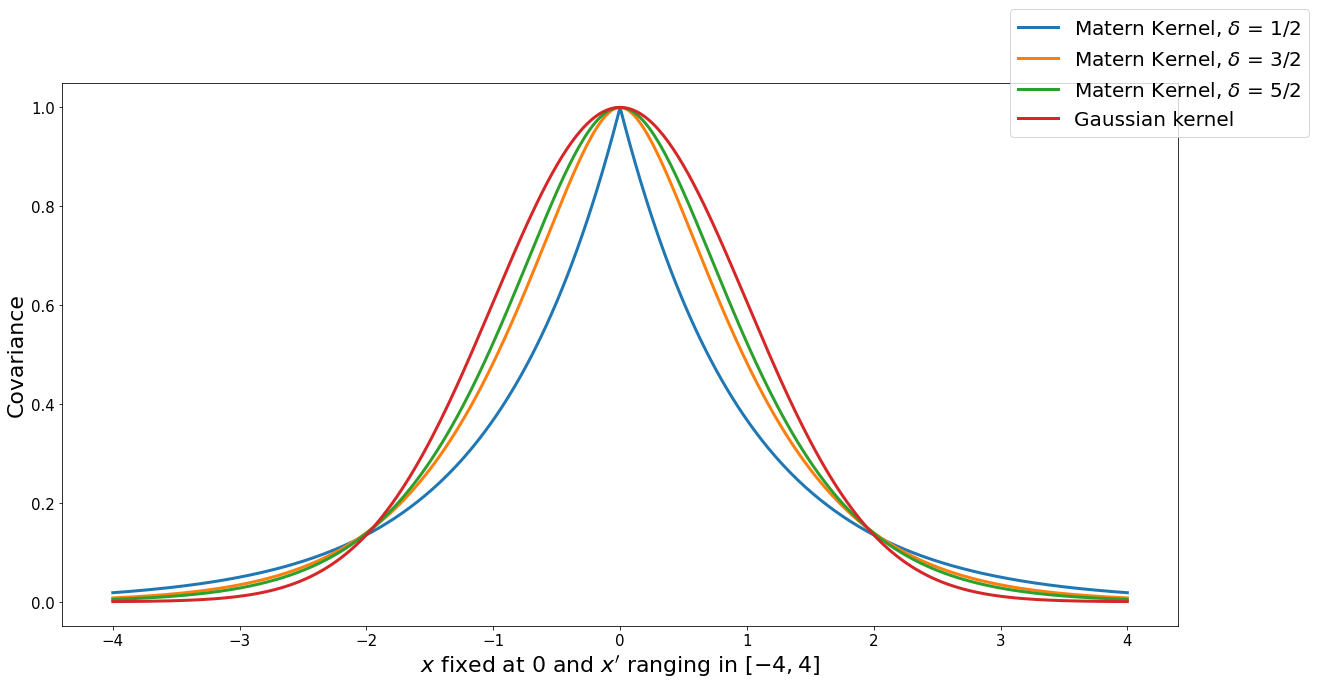

In [16]:
from scipy.special import gamma, kv

def matern_kernel(r, l = 1, v = 1):
    r = np.abs(r)
    r[r == 0] = 1e-8
    part1 = 2 ** (1 - v) / gamma(v)
    part2 = (np.sqrt(2 * v) * r / l) ** v
    part3 = kv(v, np.sqrt(2 * v) * r / l)
    return part1 * part2 * part3

def get_r(x1, x2):
    return np.subtract.outer(x1, x2)


def sqexp_kernel(r, l = 1):
    return np.exp(-0.5 * (r/l)**2)


x = np.linspace(-4, 4, 401)
fig, axes =plt.subplots(1, figsize=(20, 10))
for i in [1, 3, 5]:
    axes.plot(x, matern_kernel(x, v=i/2), linewidth=3, label=f"Matern Kernel, $\delta$ = {i}/2")

axes.plot(x, sqexp_kernel(x), linewidth=3, label="Gaussian kernel")
axes.set_ylabel("Covariance")
axes.set_xlabel("$x$ fixed at 0 and $x'$ ranging in $[-4, 4]$")
fig.legend()
# adapt_save_fig(fig, "matern.pdf")
plt.show()